# Implementation of a K nearest neighbors algorithm

K nearest neighbors is a supervised learning algorithm that in low dimensional data can be easily visualized. This method is useful for classification models and regression models. In this case it will be implemented for a classification model, and as its paremeters the user needs to establish how many groups it wants the model to predict.



# KNN implementation

## Libraries

In [1]:
import pandas as pd
import numpy as np

## External methods

In [2]:
#Other methods that don't need to belong to the class

def euclidean_distance(x1,x2): #for euclidean distance
  return np.sqrt(np.sum((x1-x2)**2))

def manhattan_distance(x1,x2): #for manhattan distance
  return np.sum(np.abs(x1-x2))

def mahalanobis_distance(x1,x2,cov_inv): #mahalanobis distance
  #cov_inv = np.linalg.inv(np.cov(X_train, rowvar=False)) passed directly from fit so its not calculated each time
  return np.sqrt(np.dot(np.dot((x1-x2), cov_inv), (x1-x2)))

def cosine_similarity(x1,x2):
  return np.dot(x1,x2)/(np.linalg.norm(x1)*np.linalg.norm(x2))

def most_common(values): #for classification target
  counts={}
  for item in values:
    counts[item]=counts.get(item, 0)+1
  sorted_counts=sorted(counts.items(),key=lambda x: x[1], reverse=True)
  return sorted_counts[0][0]

def calculate_distance(x1,x2,metric,cov_inv):
  if metric=='euclidean':
    return euclidean_distance(x1,x2)
  if metric=='manhattan':
    return manhattan_distance(x1,x2)
  if metric=='mahalanobis':
    return mahalanobis_distance(x1,x2,cov_inv)
  if metric=='cosine similarity':
    return cosine_similarity(x1,x2)
  if callable(metric):
    try:
      return metric(x1, x2)
    except ValueError as e:
      print('Error in callable function: ',e)


def find_target(nearest_y_value,target):
  if target=='classification':
    return most_common(nearest_y_value)
  if target=='regression':
    return np.mean(nearest_y_value)

def class_accuracy(y_pred, y_test):
    error=0
    for i in range(len(y_pred)):
      if y_pred[i]!=y_test[i]:
        error=error+1
    return (len(y_pred)-error)/len(y_pred)*100

def reg_accuracy(y_pred, y_test, dev):
  error=0
  for i in range(len(y_pred)):
    if abs(y_pred[i]-y_test[i])>dev:
      error=error+1
  return (len(y_pred)-error)/len(y_pred)*100

def mean_squared_error(y_pred, y_test):
  squared_errors = (y_test - y_pred) ** 2
  mse = np.mean(squared_errors)
  return mse


## Class definition

In [24]:
class KNN:

  def __init__(self, k=5, metric='euclidean',target='classification', dev=None):
    #Parameter fail safes
    if not isinstance(k, int) or k <0:
      raise ValueError('k must be a non-negative integer')
    possible_metrics={'euclidean', 'manhattan','mahalanobis', 'cosine similarity'}
    if not (isinstance(metric, str) and metric in {'euclidean', 'manhattan', 'mahalanobis', 'cosine similarity'} or callable(metric)):
      raise ValueError('Invalid metric. Allowed metrics are \'euclidean\' , \'manhattan\',\'mahalanobis\'or \'cosine similarity\'; or a callable function')
    possible_targets={'classification', 'regression'}
    if target not in possible_targets:
      raise ValueError('Invalid target. Allowed metrics are \'classification\' or \'regression\'')
    if (not isinstance(dev, int) or dev <0) and (dev is not None):
      raise ValueError('Standard deviation must be a non-negative integer')



    self.k=k #parameter amount of neighbors
    self.metric=metric #parameter type of metric
    self.target=target #parameter target (classification or regression)
    try: #parameter deviation for accepted deviation in regression models, if it isnt regression this parameter doesnt exist
      if target=='classification' and dev!=0 and (dev is not None):
        self.dev=None
        raise ValueError("Deviation won't be used in classification models, parameter ignored")
      else:
        self.dev=dev
    except ValueError as e:
      print(e)
    self.cov_inv=0

  def fit(self, X, y): #fit in KNN stores the data to compare the given point
    self.X_train=X
    self.y_train=y
    if self.metric=='mahalanobis':
      self.cov_inv=np.linalg.inv(np.cov(X, rowvar=False))
    #check that k<than amount of data points
    if self.k>len(X):
      raise ValueError("k is bigger than the amount of data points, recreate KNN with a different k, or add more data")



  def predict(self, X): # calls make prediction method for each point of X
    y_pred=[self.make_prediction(x) for x in X]
    return np.array(y_pred)


  def make_prediction(self, x):
    #calculates the distance depending on the metric chosen
    distances=[calculate_distance(x, x_train, self.metric, self.cov_inv) for x_train in self.X_train]
    #sort distance, returns indexes of the closest k
    nearest_index=np.argsort(distances)[:self.k]
    #supervised learning compares with true value, get value of closest
    nearest_y_value=[self.y_train[i] for i in nearest_index]
    if self.target=='regression' and self.dev==None:
      self.dev=np.std(nearest_y_value)
    #get y value depending on the target
    return find_target(nearest_y_value, self.target)

  def evaluate(self, y_pred, y_test, eval='accuracy', custom_dev=None):
    if self.target == 'classification':
      try:
        if eval != 'accuracy':
            raise ValueError("eval parameter is ignored in classification models, evaluation method is accuracy")
      except ValueError as e:
        print(e)
      try:
        if custom_dev is not None:
          raise ValueError("Deviation won't be used in classification models, parameter ignored")
      except ValueError as e:
        print(e)
      return class_accuracy(y_pred, y_test)
    elif self.target == 'regression':
        if eval == 'accuracy':
            if custom_dev is not None:
              if (not isinstance(custom_dev, int) or custom_dev <0) and (custom_dev is not None):
                raise ValueError('Standard deviation must be a non-negative integer')
              elif custom_dev >= (max(y_test) - min(y_test)):
                raise ValueError("Deviation higher than y range, guaranteed 100% accuracy, no significance in results")
              self.dev=custom_dev
            elif self.dev is None:
                raise ValueError("For regression evaluation with 'accuracy', you must specify a non-negative deviation (dev).")
            elif self.dev >= (max(y_test) - min(y_test)):
                raise ValueError("Deviation higher than y range, guaranteed 100% accuracy, no significance in results")
            else:
              self.dev = self.dev
            return reg_accuracy(y_pred, y_test, self.dev)
        elif eval == 'score':
            return mean_squared_error(y_pred, y_test)
        else:
            raise ValueError("Invalid eval. Allowed evaluation methods are: 'accuracy' or 'score'")
    else:
        raise ValueError("Invalid target. Allowed targets are 'classification' or 'regression'")



  def cross_validation(self, X, y, folds=5, eval='accuracy'): #cross validation for how well the model does splitting the data in different ways
    shuffle_index=np.random.permutation(len(X))
    fold_size=len(X)//folds
    fold_index=[shuffle_index[i:i+fold_size] for i in range(0, len(X), fold_size)]
    metrics=[]
    for i in range(folds):
      test_indices = fold_index[i]
      train_indices = np.concatenate([fold_index[j] for j in range(folds) if j != i])
      X_train = X[train_indices]
      y_train = y[train_indices]
      X_test = X[test_indices]
      y_test = y[test_indices]
      self.fit(X_train, y_train)
      y_pred = self.predict(X_test)
      metrics.append(self.evaluate(y_pred, y_test, eval))
    return np.mean(metrics)



# Datasets for trail runs

## Iris data set
classification toy set

In [4]:
#run this chunk to try with iris sample dataset
from sklearn import datasets
iris = datasets.load_iris()
X_c = iris.data # we only take the first two features.
y_c = iris.target

In [5]:
train_ratio = 0.75

# Calculate the number of samples for the training set
num_samples = len(X_c)
num_train_samples = int(train_ratio * num_samples)

# Create random indices for splitting
indices = np.arange(num_samples)
np.random.shuffle(indices)

# Split the data and labels into training and testing sets
X_train_c = X_c[indices[:num_train_samples]]
y_train_c = y_c[indices[:num_train_samples]]
X_test_c = X_c[indices[num_train_samples:]]
y_test_c = y_c[indices[num_train_samples:]]

## Diabetes data set
regression toy set

In [6]:
from sklearn import datasets
diabetes = datasets.load_diabetes()
X_r = diabetes.data # we only take the first two features.
y_r = diabetes.target

In [7]:
train_ratio = 0.75

# Calculate the number of samples for the training set
num_samples = len(X_r)
num_train_samples = int(train_ratio * num_samples)

# Create random indices for splitting
indices = np.arange(num_samples)
np.random.shuffle(indices)

# Split the data and labels into training and testing sets
X_train_r = X_r[indices[:num_train_samples]]
y_train_r = y_r[indices[:num_train_samples]]
X_test_r = X_r[indices[num_train_samples:]]
y_test_r = y_r[indices[num_train_samples:]]

# Trail runs

Different distances between the first two instances of iris data set

In [14]:
print(euclidean_distance(X_train_c[0],X_train_c[1]))
print(manhattan_distance(X_train_c[0],X_train_c[1]))
cov_inv=np.linalg.inv(np.cov(X_train_c, rowvar=False))
print(mahalanobis_distance(X_train_c[0],X_train_c[1],cov_inv))
print(cosine_similarity(X_train_c[0],X_train_c[1]))

0.8602325267042629
1.4000000000000001
1.97804360077469
0.9977075515390801


Variations in k for classifiction

In [15]:
knn3=KNN(k=3)
knn3.fit(X_train_c, y_train_c)
y_pred=knn3.predict(X_test_c)
print(knn3.evaluate(y_pred,y_test_c))

knn5=KNN(k=5)
knn5.fit(X_train_c, y_train_c)
y_pred=knn5.predict(X_test_c)
print(knn5.evaluate(y_pred,y_test_c))

knn10=KNN(k=10)
knn10.fit(X_train_c, y_train_c)
y_pred=knn10.predict(X_test_c)
print(knn10.evaluate(y_pred,y_test_c))

try:
  knn_not_k=KNN(k=(len(X_train_c)+1)) # giving a wrong value for the parameter
  knn_not_k.fit(X_train_c, y_train_c)
except ValueError as e:
  print(f"Exception caught: {e}")

92.10526315789474
94.73684210526315
94.73684210526315
Exception caught: k is bigger than the amount of data points, recreate KNN with a different k, or add more data


Comparing different metrics for iris dataset (classification)

In [16]:
knn1=KNN(k=5,metric='euclidean') #euclidean distance
knn1.fit(X_train_c, y_train_c)
y_pred=knn1.predict(X_test_c)
print(knn1.evaluate(y_pred,y_test_c))

knn2=KNN(k=5,metric='manhattan') #manhattan distance
knn2.fit(X_train_c, y_train_c)
y_pred=knn2.predict(X_test_c)
print(knn2.evaluate(y_pred,y_test_c))

knn3=KNN(k=5,metric='mahalanobis') #mahalanobis distance
knn3.fit(X_train_c, y_train_c)
y_pred=knn3.predict(X_test_c)
print(knn3.evaluate(y_pred,y_test_c))

knn4=KNN(k=5,metric='cosine similarity') #cosine similarity distance
knn4.fit(X_train_c, y_train_c)
y_pred=knn4.predict(X_test_c)
print(knn4.evaluate(y_pred,y_test_c))

knn4=KNN(k=5,metric=euclidean_distance) #euclidean distance passing the external function directly as a callable function
knn4.fit(X_train_c, y_train_c)
y_pred=knn4.predict(X_test_c)
print(knn4.evaluate(y_pred,y_test_c))

try:
  knn_not_metric=KNN(metric='not metric') # giving a wrong value for the parameter
except ValueError as e:
  print(f"Exception caught: {e}")

94.73684210526315
92.10526315789474
86.8421052631579
0.0
94.73684210526315
Exception caught: Invalid metric. Allowed metrics are 'euclidean' , 'manhattan','mahalanobis'or 'cosine similarity'; or a callable function


Trying different evaluation methods for classification

In [26]:
knn2=KNN()
knn2.fit(X_train_c, y_train_c)
y_pred=knn2.predict(X_test_c)
print(knn2.evaluate(y_pred,y_test_c, eval='accuracy'))

knn4=KNN()
knn4.fit(X_train_c, y_train_c)
y_pred=knn4.predict(X_test_c)
print(knn4.evaluate(y_pred,y_test_c, eval='score'))

knn6=KNN()
knn6.fit(X_train_c, y_train_c)
y_pred=knn6.predict(X_test_c)
print(knn6.evaluate(y_pred,y_test_c, custom_dev=1))


94.73684210526315
eval parameter is ignored in classification models, evaluation method is accuracy
94.73684210526315
Deviation won't be used in classification models, parameter ignored
94.73684210526315


Performing cross validation for the best parameters found

In [27]:
knn_cv=KNN(k=10, metric='euclidean')
knn_cv.cross_validation(X_c, y_c)

96.0

Variations in k for regression (long computation type due to brute force search type)

In [28]:
knn3=KNN(k=5,target='regression')
knn3.fit(X_train_r, y_train_r)
y_pred=knn3.predict(X_test_r)
print(knn3.evaluate(y_pred,y_test_r))

knn5=KNN(k=10,target='regression')
knn5.fit(X_train_r, y_train_r)
y_pred=knn5.predict(X_test_r)
print(knn5.evaluate(y_pred,y_test_r))

knn10=KNN(k=20,target='regression')
knn10.fit(X_train_r, y_train_r)
y_pred=knn10.predict(X_test_r)
print(knn10.evaluate(y_pred,y_test_r))

try:
  knn_not_k=KNN(k=(len(X_train_r)+1), target='regression') # giving a wrong value for the parameter
  knn_not_k.fit(X_train_c, y_train_c)
except ValueError as e:
  print(f"Exception caught: {e}")

72.97297297297297
65.76576576576578
66.66666666666666
Exception caught: k is bigger than the amount of data points, recreate KNN with a different k, or add more data


Comparing different metrics for regression, using best k found.

In [29]:
knn1=KNN(k=20,metric='euclidean',target='regression')
knn1.fit(X_train_r, y_train_r)
y_pred=knn1.predict(X_test_r)
print(knn1.evaluate(y_pred,y_test_r))

knn2=KNN(k=20,metric='manhattan',target='regression')
knn2.fit(X_train_r, y_train_r)
y_pred=knn2.predict(X_test_r)
print(knn2.evaluate(y_pred,y_test_r))

knn3=KNN(k=20,metric='mahalanobis',target='regression')
knn3.fit(X_train_r, y_train_r)
y_pred=knn3.predict(X_test_r)
print(knn3.evaluate(y_pred,y_test_r))

knn4=KNN(k=20,metric='cosine similarity',target='regression')
knn4.fit(X_train_r, y_train_r)
y_pred=knn4.predict(X_test_r)
print(knn4.evaluate(y_pred,y_test_r))

66.66666666666666
66.66666666666666
62.16216216216216
27.027027027027028


Comparing different dev for regression, using best k and best metric found.

In [30]:
knn1=KNN(k=20,metric='manhattan',target='regression', dev=None) #std of k nearest
knn1.fit(X_train_r, y_train_r)
y_pred=knn1.predict(X_test_r)
print(knn1.evaluate(y_pred,y_test_r))

print('\nImportant values:')
print('Standard Deviation of k nearest in default:', knn1.dev)
print('Range of possible y values: ',max(y_test_r)-min(y_test_r),'\n')

knn2=KNN(k=20,metric='manhattan',target='regression', dev=30) #10% of range
knn2.fit(X_train_r, y_train_r)
y_pred=knn2.predict(X_test_r)
print(knn2.evaluate(y_pred,y_test_r))

knn3=KNN(k=20,metric='manhattan',target='regression', dev=80) # More than the std dev
knn3.fit(X_train_r, y_train_r)
y_pred=knn3.predict(X_test_r)
print(knn3.evaluate(y_pred,y_test_r))

knn4=KNN(k=20,metric='manhattan',target='regression', dev=307) #Range, guaranteed 100%
knn4.fit(X_train_r, y_train_r)
y_pred=knn4.predict(X_test_r)
try:
  knn4.evaluate(y_pred,y_test_r)
except ValueError as e:
  print(f"Exception caught: {e}")

66.66666666666666

Important values:
Standard Deviation of k nearest in default: 56.75497775525949
Range of possible y values:  277.0 

36.93693693693694
85.58558558558559
Exception caught: Deviation higher than y range, guaranteed 100% accuracy, no significance in results


Evaluate same model for varios dev (set in the evaluate function)

In [35]:
knn1=KNN(k=20,metric='manhattan',target='regression') #std of k nearest
knn1.fit(X_train_r, y_train_r)
y_pred=knn1.predict(X_test_r)
dev=[-1,0,20,30,100,500]
for i in range(len(dev)):
  try:
    print(knn1.evaluate(y_pred,y_test_r, custom_dev=dev[i]))
  except ValueError as e:
    print(f"Exception caught: {e}")

Exception caught: Standard deviation must be a non-negative integer
0.9009009009009009
27.027027027027028
36.93693693693694
93.69369369369369
Exception caught: Deviation higher than y range, guaranteed 100% accuracy, no significance in results


Comparing different evaluation methods for regression models

In [36]:
knn1=KNN(k=20,metric='manhattan',target='regression')
knn1.fit(X_train_r, y_train_r)
y_pred=knn1.predict(X_test_r)
print(knn1.evaluate(y_pred,y_test_r, eval='accuracy'))

knn2=KNN(k=20,metric='manhattan',target='regression')
knn2.fit(X_train_r, y_train_r)
y_pred=knn2.predict(X_test_r)
print(knn2.evaluate(y_pred,y_test_r, eval='score'))

knn4=KNN(k=20,metric='manhattan',target='regression')
knn4.fit(X_train_r, y_train_r)
y_pred=knn4.predict(X_test_r)
try:
  knn4.evaluate(y_pred,y_test_r, eval='not a method')
except ValueError as e:
  print(f"Exception caught: {e}")

66.66666666666666
3173.687837837838
Exception caught: Invalid eval. Allowed evaluation methods are: 'accuracy' or 'score'


Performing cross_validation for the parameters found

In [37]:
knn_cv_r=KNN(k=20, metric='manhattan', target='regression')
knn_cv_r.cross_validation(X_r, y_r, folds=10)

77.27272727272728

# Apendix
## Graphic visualization of KNN (no model)

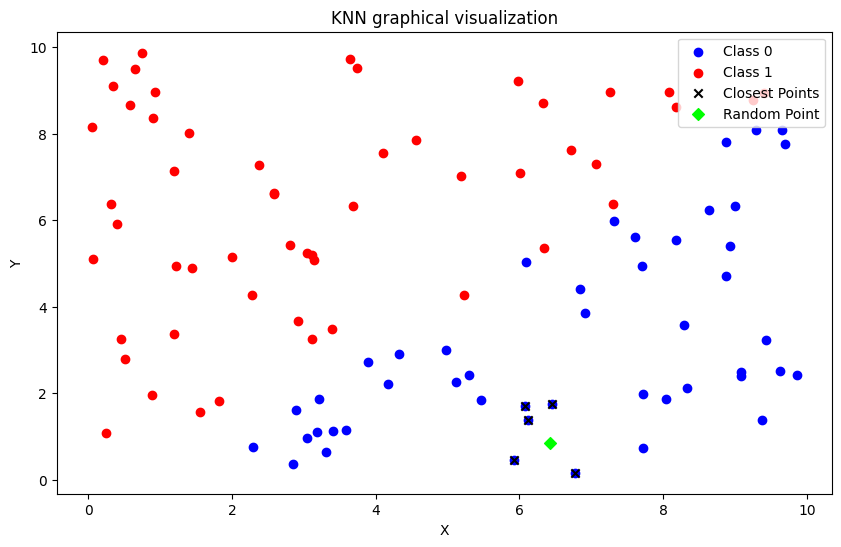

In [34]:
import matplotlib.pyplot as plt

# Set a random seed for reproducibility
np.random.seed(42)

# Number of data points
num_points = 100

# Generate random data points in 2D
data_points = np.random.rand(num_points, 2) * 10  # Generating points in the range [0, 10)

#classifing data points with y=x-1
y = np.where(data_points[:, 1] > 1 * data_points[:, 0] -1, 1, 0)

# Generate a random point
random_point = np.random.rand(2) * 10  # Generating a random point in the same range [0, 10)

# Calculate the Euclidean distances between the random point and all data points
distances = np.linalg.norm(data_points - random_point, axis=1)

# Find the indices of the 5 closest points
closest_indices = np.argsort(distances)[:5]

# Extract the coordinates of the 5 closest points
closest_points = data_points[closest_indices]

# Create a scatter plot of the data points with different markers and colors
plt.figure(figsize=(10, 6))
plt.scatter(data_points[y == 0, 0], data_points[y == 0, 1], c='blue', label='Class 0', marker='o')
plt.scatter(data_points[y == 1, 0], data_points[y == 1, 1], c='red', label='Class 1', marker='o')
plt.scatter(closest_points[:, 0], closest_points[:, 1],c='black', label='Closest Points', marker='x')
plt.scatter(random_point[0], random_point[1], c='lime', label='Random Point', marker='D')

# Add labels and a legend
plt.xlabel('X')
plt.ylabel('Y')
plt.title('KNN graphical visualization')
plt.legend(loc='upper right')

# Show the plot
plt.show()
